# Q3 Analysis: Missing Constitutional Isomers

This notebook analyzes model performance on Q3 tasks (identifying missing constitutional isomers from a set) with:
- Precision, Recall, and F1 score metrics
- Exact match accuracy
- Stratification by molecular properties and task difficulty

In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import defaultdict, Counter
from pathlib import Path
from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors

# Set style for plots - clean, no grid
sns.set_style("white")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

custom_colors = ['#FF6B35', '#2E86AB', '#06A77D']  # Orange, Blue, Teal - high contrast

## Helper Functions

In [2]:
def get_molecular_weight(smiles):
    """Calculate molecular weight"""
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    return Descriptors.MolWt(mol)

def get_molecular_formula(smiles):
    """Get molecular formula"""
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    return rdMolDescriptors.CalcMolFormula(mol)

def count_elements_in_formula(formula):
    """Count number of unique elements in molecular formula"""
    if formula is None:
        return None
    
    import re
    elements = re.findall(r'([A-Z][a-z]?)', formula)
    return len(set(elements))

def count_atoms_in_formula(formula):
    """Count total number of atoms in molecular formula"""
    if formula is None:
        return None
    
    import re
    pattern = r'([A-Z][a-z]?)(\d*)'
    matches = re.findall(pattern, formula)
    
    total = 0
    for element, count in matches:
        if count == '':
            total += 1
        else:
            total += int(count)
    return total

def get_num_heavy_atoms(smiles):
    """Get number of heavy atoms"""
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    return mol.GetNumHeavyAtoms()

## Load Data

In [3]:
# Load the dataset to get ground truth and metadata
dataset = []
with open('data/dataset_q3.jsonl', 'r') as f:
    for line in f:
        dataset.append(json.loads(line))

# Filter for Q3 tasks only
q3_dataset = [d for d in dataset if d['task'] == 'q3_missing_isomers']

# Create a lookup by instance ID
dataset_lookup = {d['id']: d for d in q3_dataset}

print(f"Total Q3 instances in dataset: {len(q3_dataset)}")
print(f"Tasks: {set(d['task'] for d in q3_dataset)}")

Total Q3 instances in dataset: 1000
Tasks: {'q3_missing_isomers'}


In [4]:
# Define the runs to analyze
run_files = [
    ('claude-opus-4-5', 'runs/claude-opus-4-5-20251101_parallel/q3_missing_isomers.jsonl'),
    ('gpt-5.2', 'runs/gpt-5.2_parallel/q3_missing_isomers.jsonl'),
    ('gemini-3-pro-preview', 'runs/gemini-3-pro-preview_parallel/q3_missing_isomers_v2.jsonl'),
]

# Load all runs
all_results = []

for model_name, file_path in run_files:
    if not Path(file_path).exists():
        print(f"Warning: {file_path} not found, skipping...")
        continue
    
    with open(file_path, 'r') as f:
        for line in f:
            result = json.loads(line)
            result['model_name'] = model_name
            all_results.append(result)

print(f"\nTotal results loaded: {len(all_results)}")
print(f"Models: {set(r['model_name'] for r in all_results)}")


Total results loaded: 3000
Models: {'claude-opus-4-5', 'gemini-3-pro-preview', 'gpt-5.2'}


## Compute Enriched Metrics

In [5]:
# Enrich results with molecular properties
enriched_results = []

for result in all_results:
    instance_id = result['id']
    
    # Get dataset info
    if instance_id not in dataset_lookup:
        print(f"Warning: {instance_id} not found in dataset")
        continue
    
    dataset_info = dataset_lookup[instance_id]
    
    # Extract metrics from score
    score = result['score']
    precision = score.get('precision', 0.0)
    recall = score.get('recall', 0.0)
    f1 = score.get('f1', 0.0)
    exact_match = score.get('correct', False)
    
    # Get prediction info
    tp = score.get('tp', 0)
    fp = score.get('fp', 0)
    fn = score.get('fn', 0)
    
    n_predicted = len(score.get('pred_canonical', []))
    n_gold = len(score.get('gold_canonical', []))
    
    # Calculate molecular properties from given molecules
    given_molecules = dataset_info['molecules']
    
    # Get formula from metadata
    formula = dataset_info.get('metadata', {}).get('formula')
    universe_size = dataset_info.get('metadata', {}).get('universe_size')
    given_size = dataset_info.get('metadata', {}).get('given_size', len(given_molecules))
    
    # Calculate properties from first given molecule
    if given_molecules:
        first_molecule = given_molecules[0]
        mol_weight = get_molecular_weight(first_molecule)
        if formula is None:
            formula = get_molecular_formula(first_molecule)
    else:
        mol_weight = None
    
    n_elements = count_elements_in_formula(formula)
    n_atoms = count_atoms_in_formula(formula)
    
    # Calculate average properties of given molecules
    all_weights = [get_molecular_weight(m) for m in given_molecules]
    all_weights = [w for w in all_weights if w is not None]
    avg_mol_weight = np.mean(all_weights) if all_weights else None
    
    all_heavy_atoms = [get_num_heavy_atoms(m) for m in given_molecules]
    all_heavy_atoms = [a for a in all_heavy_atoms if a is not None]
    avg_heavy_atoms = np.mean(all_heavy_atoms) if all_heavy_atoms else None
    
    enriched = {
        'id': instance_id,
        'model': result['model_name'],
        'task': result['task'],
        'n_molecules': result['n_molecules'],  # Number of GIVEN molecules
        'n_missing': n_gold,  # Number of missing isomers to find
        'n_total': n_gold + result['n_molecules'],
        'n_predicted': n_predicted,
        'universe_size': universe_size,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'exact_match': exact_match,
        'tp': tp,
        'fp': fp,
        'fn': fn,
        'molecular_weight': mol_weight,
        'avg_molecular_weight': avg_mol_weight,
        'formula': formula,
        'n_elements': n_elements,
        'n_atoms_formula': n_atoms,
        'avg_heavy_atoms': avg_heavy_atoms,
    }
    
    enriched_results.append(enriched)

# Convert to DataFrame
df = pd.DataFrame(enriched_results)

print(f"\nEnriched results: {len(df)} instances")
print(f"\nSample of enriched data:")
print(df.head())


Enriched results: 3000 instances

Sample of enriched data:
                id            model                task  n_molecules  \
0  q3_given5_00301  claude-opus-4-5  q3_missing_isomers            5   
1  q3_given5_00302  claude-opus-4-5  q3_missing_isomers            5   
2  q3_given5_00303  claude-opus-4-5  q3_missing_isomers            5   
3  q3_given5_00304  claude-opus-4-5  q3_missing_isomers            5   
4  q3_given5_00305  claude-opus-4-5  q3_missing_isomers            5   

   n_missing  n_total  n_predicted  universe_size  precision    recall  ...  \
0         23       28           14             88   0.571429  0.347826  ...   
1         33       38           23             37   0.956522  0.666667  ...   
2         15       20           19             17   0.631579  0.800000  ...   
3         22       27           17             97   0.411765  0.318182  ...   
4         31       36           14             35   0.571429  0.258065  ...   

   exact_match  tp  fp  fn  mole

In [6]:
# Overall statistics
print("=" * 80)
print("OVERALL STATISTICS")
print("=" * 80)

for model in df['model'].unique():
    subset = df[df['model'] == model]
    
    print(f"\n{model}:")
    print(f"  Total instances: {len(subset)}")
    print(f"  " + "-" * 60)
    print(f"  Exact Match Accuracy: {subset['exact_match'].mean():.3f}")
    print(f"  " + "-" * 60)
    print(f"  Average Precision: {subset['precision'].mean():.3f}")
    print(f"  Average Recall: {subset['recall'].mean():.3f}")
    print(f"  Average F1 Score: {subset['f1'].mean():.3f}")
    print(f"  " + "-" * 60)
    print(f"  Average # Missing (gold): {subset['n_missing'].mean():.1f}")
    print(f"  Average # Predicted: {subset['n_predicted'].mean():.1f}")
    print(f"  Average TP: {subset['tp'].mean():.1f}")
    print(f"  Average FP: {subset['fp'].mean():.1f}")
    print(f"  Average FN: {subset['fn'].mean():.1f}")
    print(f"  " + "-" * 60)
    print(f"  No predictions (predicted 0): {(subset['n_predicted'] == 0).sum()} ({(subset['n_predicted'] == 0).mean():.1%})")

OVERALL STATISTICS

claude-opus-4-5:
  Total instances: 1000
  ------------------------------------------------------------
  Exact Match Accuracy: 0.000
  ------------------------------------------------------------
  Average Precision: 0.446
  Average Recall: 0.304
  Average F1 Score: 0.322
  ------------------------------------------------------------
  Average # Missing (gold): 29.5
  Average # Predicted: 16.4
  Average TP: 7.6
  Average FP: 8.9
  Average FN: 21.9
  ------------------------------------------------------------
  No predictions (predicted 0): 0 (0.0%)

gpt-5.2:
  Total instances: 1000
  ------------------------------------------------------------
  Exact Match Accuracy: 0.001
  ------------------------------------------------------------
  Average Precision: 0.258
  Average Recall: 0.129
  Average F1 Score: 0.141
  ------------------------------------------------------------
  Average # Missing (gold): 29.5
  Average # Predicted: 13.9
  Average TP: 3.1
  Average FP: 

## Visualizations

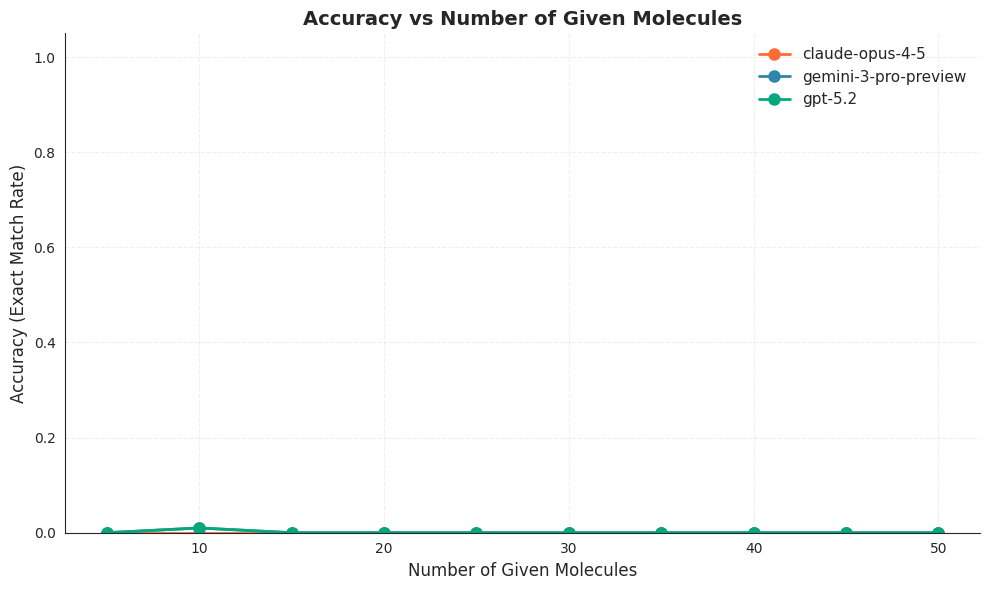

In [7]:
# Plot Accuracy vs Number of Given Molecules
fig, ax = plt.subplots(figsize=(10, 6))

# Create color mapping for models
models = sorted(df['model'].unique())
color_map = {model: custom_colors[i % len(custom_colors)] for i, model in enumerate(models)}

# Plot accuracy for each model
for model in models:
    subset = df[df['model'] == model]
    grouped = subset.groupby('n_molecules')['exact_match'].mean().reset_index()
    ax.plot(grouped['n_molecules'], grouped['exact_match'], marker='o', label=model, 
            linewidth=2, markersize=8, color=color_map[model])

ax.set_xlabel('Number of Given Molecules', fontsize=12)
ax.set_ylabel('Accuracy (Exact Match Rate)', fontsize=12)
ax.set_title('Accuracy vs Number of Given Molecules', fontsize=14, fontweight='bold')
ax.legend(frameon=False, fontsize=11)
ax.set_ylim([0, 1.05])
ax.grid(True, alpha=0.3, linestyle='--')
sns.despine(ax=ax)

plt.tight_layout()
plt.show()

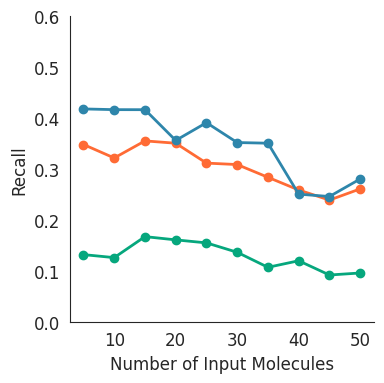

In [21]:
plt.rcParams['font.size'] = 12
fig, axes = plt.subplots(1,1, figsize=(4, 4))

# Create color mapping for models
models = sorted(df['model'].unique())
color_map = {model: custom_colors[i % len(custom_colors)] for i, model in enumerate(models)}

ax2 = axes
for model in models:
    subset = df[df['model'] == model]
    grouped = subset.groupby('n_molecules')['recall'].mean().reset_index()
    ax2.plot(grouped['n_molecules'], grouped['recall'], marker='o', label=model, 
             linewidth=2, color=color_map[model])
ax2.set_xlabel('Number of Input Molecules')
ax2.set_ylabel('Recall')
# ax2.set_title('Recall vs Number of Input Molecules')
# ax2.legend(frameon=False)
ax2.set_ylim([0, 0.6])
sns.despine(ax=ax2)

# fig.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.05), frameon=False)
plt.tight_layout()
plt.show()


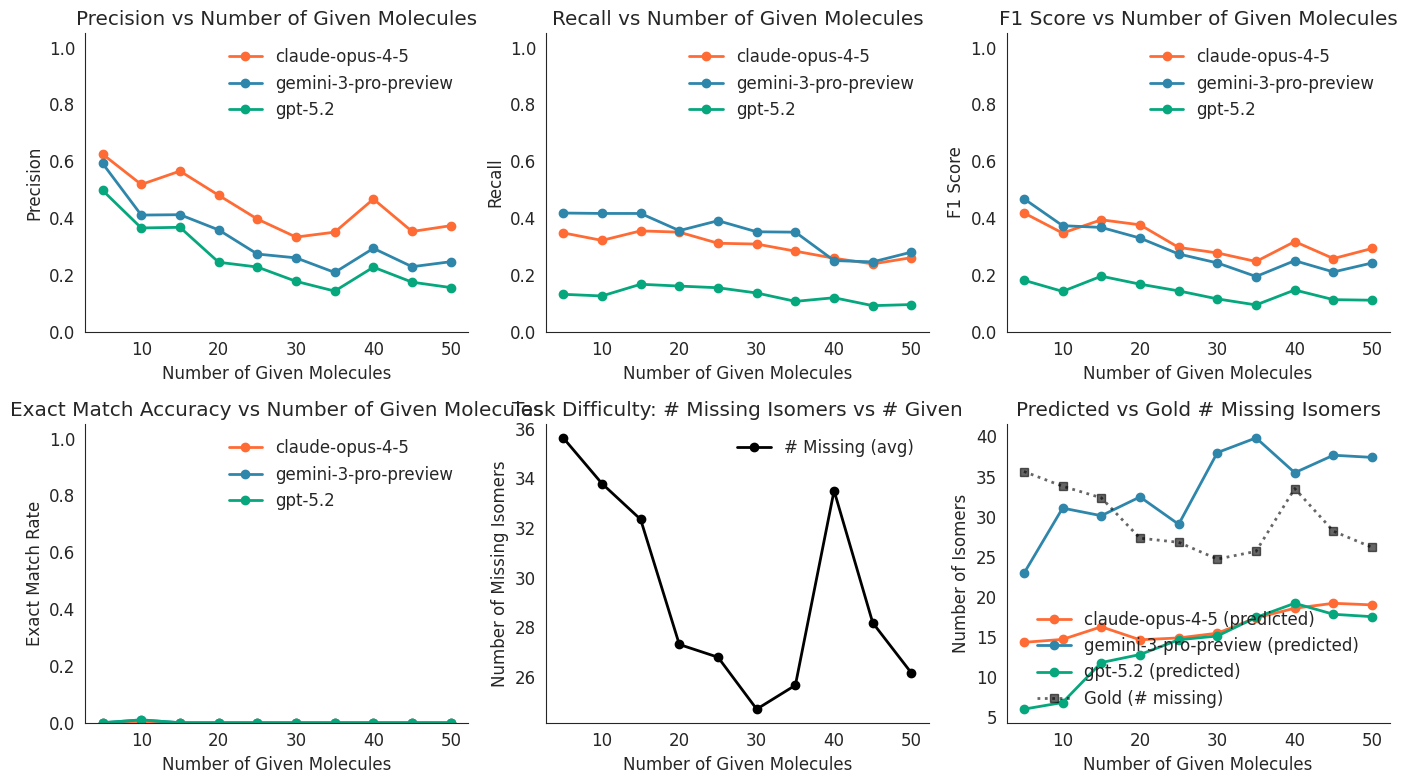

In [9]:
# Stratify by n_molecules (number of GIVEN molecules)
fig, axes = plt.subplots(2, 3, figsize=(14, 8))

# Create color mapping for models
models = sorted(df['model'].unique())
color_map = {model: custom_colors[i % len(custom_colors)] for i, model in enumerate(models)}

# Precision by n_molecules
ax1 = axes[0, 0]
for model in models:
    subset = df[df['model'] == model]
    grouped = subset.groupby('n_molecules')['precision'].mean().reset_index()
    ax1.plot(grouped['n_molecules'], grouped['precision'], marker='o', label=model, 
             linewidth=2, color=color_map[model])
ax1.set_xlabel('Number of Given Molecules')
ax1.set_ylabel('Precision')
ax1.set_title('Precision vs Number of Given Molecules')
ax1.legend(frameon=False)
ax1.set_ylim([0, 1.05])
sns.despine(ax=ax1)

# Recall by n_molecules
ax2 = axes[0, 1]
for model in models:
    subset = df[df['model'] == model]
    grouped = subset.groupby('n_molecules')['recall'].mean().reset_index()
    ax2.plot(grouped['n_molecules'], grouped['recall'], marker='o', label=model, 
             linewidth=2, color=color_map[model])
ax2.set_xlabel('Number of Given Molecules')
ax2.set_ylabel('Recall')
ax2.set_title('Recall vs Number of Given Molecules')
ax2.legend(frameon=False)
ax2.set_ylim([0, 1.05])
sns.despine(ax=ax2)

# F1 by n_molecules
ax3 = axes[0, 2]
for model in models:
    subset = df[df['model'] == model]
    grouped = subset.groupby('n_molecules')['f1'].mean().reset_index()
    ax3.plot(grouped['n_molecules'], grouped['f1'], marker='o', label=model, 
             linewidth=2, color=color_map[model])
ax3.set_xlabel('Number of Given Molecules')
ax3.set_ylabel('F1 Score')
ax3.set_title('F1 Score vs Number of Given Molecules')
ax3.legend(frameon=False)
ax3.set_ylim([0, 1.05])
sns.despine(ax=ax3)

# Exact match by n_molecules
ax4 = axes[1, 0]
for model in models:
    subset = df[df['model'] == model]
    grouped = subset.groupby('n_molecules')['exact_match'].mean().reset_index()
    ax4.plot(grouped['n_molecules'], grouped['exact_match'], marker='o', label=model, 
             linewidth=2, color=color_map[model])
ax4.set_xlabel('Number of Given Molecules')
ax4.set_ylabel('Exact Match Rate')
ax4.set_title('Exact Match Accuracy vs Number of Given Molecules')
ax4.legend(frameon=False)
ax4.set_ylim([0, 1.05])
sns.despine(ax=ax4)

# Average # missing vs given
ax5 = axes[1, 1]
grouped = df.groupby('n_molecules')['n_missing'].mean().reset_index()
ax5.plot(grouped['n_molecules'], grouped['n_missing'], marker='o', label='# Missing (avg)', 
         linewidth=2, color='black')
ax5.set_xlabel('Number of Given Molecules')
ax5.set_ylabel('Number of Missing Isomers')
ax5.set_title('Task Difficulty: # Missing Isomers vs # Given')
ax5.legend(frameon=False)
sns.despine(ax=ax5)

# Predicted vs missing
ax6 = axes[1, 2]
for model in models:
    subset = df[df['model'] == model]
    grouped = subset.groupby('n_molecules')['n_predicted'].mean().reset_index()
    ax6.plot(grouped['n_molecules'], grouped['n_predicted'], marker='o', 
             label=f"{model} (predicted)", linewidth=2, color=color_map[model])
# Add gold line
grouped_gold = df.groupby('n_molecules')['n_missing'].mean().reset_index()
ax6.plot(grouped_gold['n_molecules'], grouped_gold['n_missing'], marker='s', 
        label='Gold (# missing)', linestyle=':', linewidth=2, color='black', alpha=0.6)
ax6.set_xlabel('Number of Given Molecules')
ax6.set_ylabel('Number of Isomers')
ax6.set_title('Predicted vs Gold # Missing Isomers')
ax6.legend(frameon=False)
sns.despine(ax=ax6)

plt.tight_layout()
plt.show()

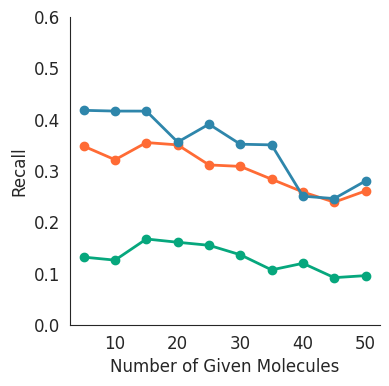

In [22]:
fig, axes = plt.subplots(1,1, figsize=(4,4))

# Recall by n_molecules
ax2 = axes
for model in models:
    subset = df[df['model'] == model]
    grouped = subset.groupby('n_molecules')['recall'].mean().reset_index()
    ax2.plot(grouped['n_molecules'], grouped['recall'], marker='o', label=model, 
             linewidth=2, color=color_map[model])
ax2.set_xlabel('Number of Given Molecules')
ax2.set_ylabel('Recall')
ax2.set_ylim([0, 0.6])
sns.despine(ax=ax2)

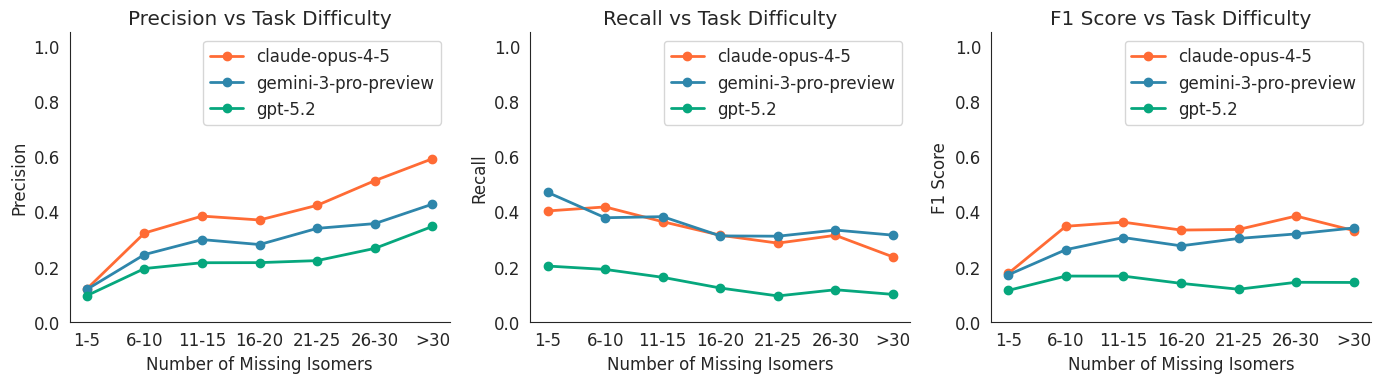

In [11]:
# Stratify by number of missing isomers (task difficulty)
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# Create color mapping for models
models = sorted(df['model'].unique())
color_map = {model: custom_colors[i % len(custom_colors)] for i, model in enumerate(models)}

# Create bins for n_missing
df['n_missing_bin'] = pd.cut(df['n_missing'], bins=[0, 5, 10, 15, 20, 25, 30, 1000], labels=['1-5', '6-10', '11-15', '16-20', '21-25', '26-30', '>30'])

# Precision by n_missing
ax1 = axes[0]
for model in models:
    subset = df[df['model'] == model]
    grouped = subset.groupby('n_missing_bin', observed=True)['precision'].mean().reset_index()
    ax1.plot(grouped['n_missing_bin'], grouped['precision'], marker='o', label=model, 
             linewidth=2, color=color_map[model])
ax1.set_xlabel('Number of Missing Isomers')
ax1.set_ylabel('Precision')
ax1.set_title('Precision vs Task Difficulty')
ax1.legend()
ax1.set_ylim([0, 1.05])
sns.despine(ax=ax1)

# Recall by n_missing
ax2 = axes[1]
for model in models:
    subset = df[df['model'] == model]
    grouped = subset.groupby('n_missing_bin', observed=True)['recall'].mean().reset_index()
    ax2.plot(grouped['n_missing_bin'], grouped['recall'], marker='o', label=model, 
             linewidth=2, color=color_map[model])
ax2.set_xlabel('Number of Missing Isomers')
ax2.set_ylabel('Recall')
ax2.set_title('Recall vs Task Difficulty')
ax2.legend()
ax2.set_ylim([0, 1.05])
sns.despine(ax=ax2)

# F1 by n_missing
ax3 = axes[2]
for model in models:
    subset = df[df['model'] == model]
    grouped = subset.groupby('n_missing_bin', observed=True)['f1'].mean().reset_index()
    ax3.plot(grouped['n_missing_bin'], grouped['f1'], marker='o', label=model, 
             linewidth=2, color=color_map[model])
ax3.set_xlabel('Number of Missing Isomers')
ax3.set_ylabel('F1 Score')
ax3.set_title('F1 Score vs Task Difficulty')
ax3.legend()
ax3.set_ylim([0, 1.05])
sns.despine(ax=ax3)

plt.tight_layout()
plt.show()

([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, '1-5'),
  Text(1, 0, '6-10'),
  Text(2, 0, '11-15'),
  Text(3, 0, '16-20'),
  Text(4, 0, '21-25'),
  Text(5, 0, '26-30'),
  Text(6, 0, '>30')])

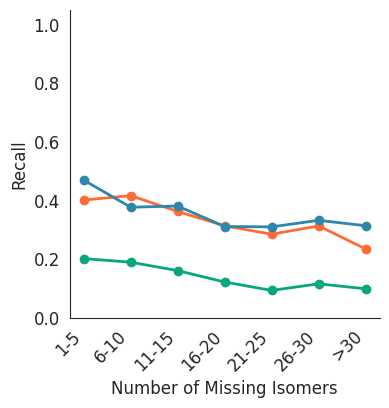

In [12]:
# Recall by n_missing
fig, axes = plt.subplots(1,1, figsize=(4,4))
ax2 = axes
for model in models:
    subset = df[df['model'] == model]
    grouped = subset.groupby('n_missing_bin', observed=True)['recall'].mean().reset_index()
    ax2.plot(grouped['n_missing_bin'], grouped['recall'], marker='o', label=model, 
             linewidth=2, color=color_map[model])
ax2.set_xlabel('Number of Missing Isomers')
ax2.set_ylabel('Recall')
ax2.set_ylim([0, 1.05])
sns.despine(ax=ax2)
plt.xticks(rotation=45, ha='right')

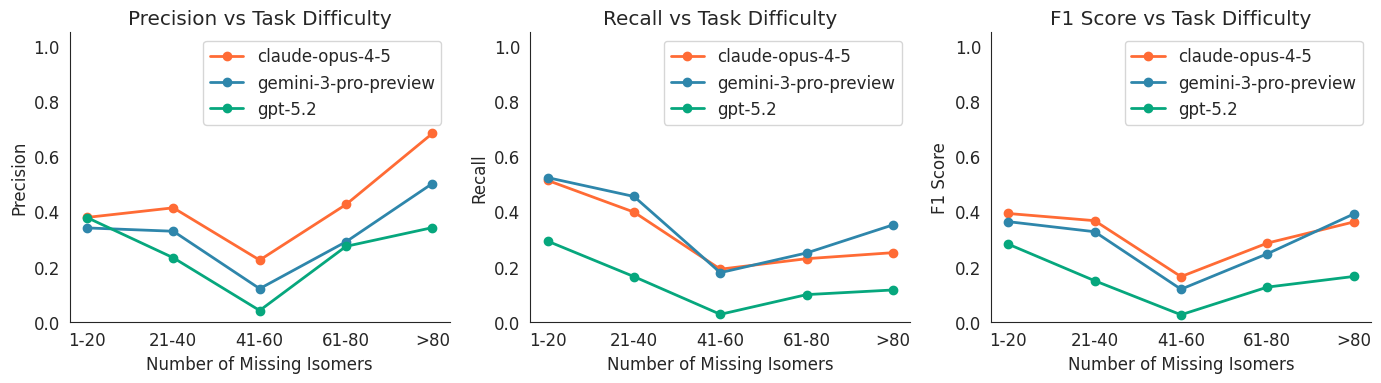

In [13]:
# Stratify by number of missing isomers (task difficulty)
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# Create color mapping for models
models = sorted(df['model'].unique())
color_map = {model: custom_colors[i % len(custom_colors)] for i, model in enumerate(models)}

# Create bins for n_total
df['n_total_bin'] = pd.cut(df['n_total'], bins=[0, 20, 40, 60, 80, 1000], labels=[
    '1-20', '21-40', '41-60', '61-80', '>80'
])

# Precision by n_total
ax1 = axes[0]
for model in models:
    subset = df[df['model'] == model]
    grouped = subset.groupby('n_total_bin', observed=True)['precision'].mean().reset_index()
    ax1.plot(grouped['n_total_bin'], grouped['precision'], marker='o', label=model, 
             linewidth=2, color=color_map[model])
ax1.set_xlabel('Number of Missing Isomers')
ax1.set_ylabel('Precision')
ax1.set_title('Precision vs Task Difficulty')
ax1.legend()
ax1.set_ylim([0, 1.05])
sns.despine(ax=ax1)

# Recall by n_total
ax2 = axes[1]
for model in models:
    subset = df[df['model'] == model]
    grouped = subset.groupby('n_total_bin', observed=True)['recall'].mean().reset_index()
    ax2.plot(grouped['n_total_bin'], grouped['recall'], marker='o', label=model, 
             linewidth=2, color=color_map[model])
ax2.set_xlabel('Number of Missing Isomers')
ax2.set_ylabel('Recall')
ax2.set_title('Recall vs Task Difficulty')
ax2.legend()
ax2.set_ylim([0, 1.05])
sns.despine(ax=ax2)

# F1 by n_total
ax3 = axes[2]
for model in models:
    subset = df[df['model'] == model]
    grouped = subset.groupby('n_total_bin', observed=True)['f1'].mean().reset_index()
    ax3.plot(grouped['n_total_bin'], grouped['f1'], marker='o', label=model, 
             linewidth=2, color=color_map[model])
ax3.set_xlabel('Number of Missing Isomers')
ax3.set_ylabel('F1 Score')
ax3.set_title('F1 Score vs Task Difficulty')
ax3.legend()
ax3.set_ylim([0, 1.05])
sns.despine(ax=ax3)

plt.tight_layout()
plt.show()

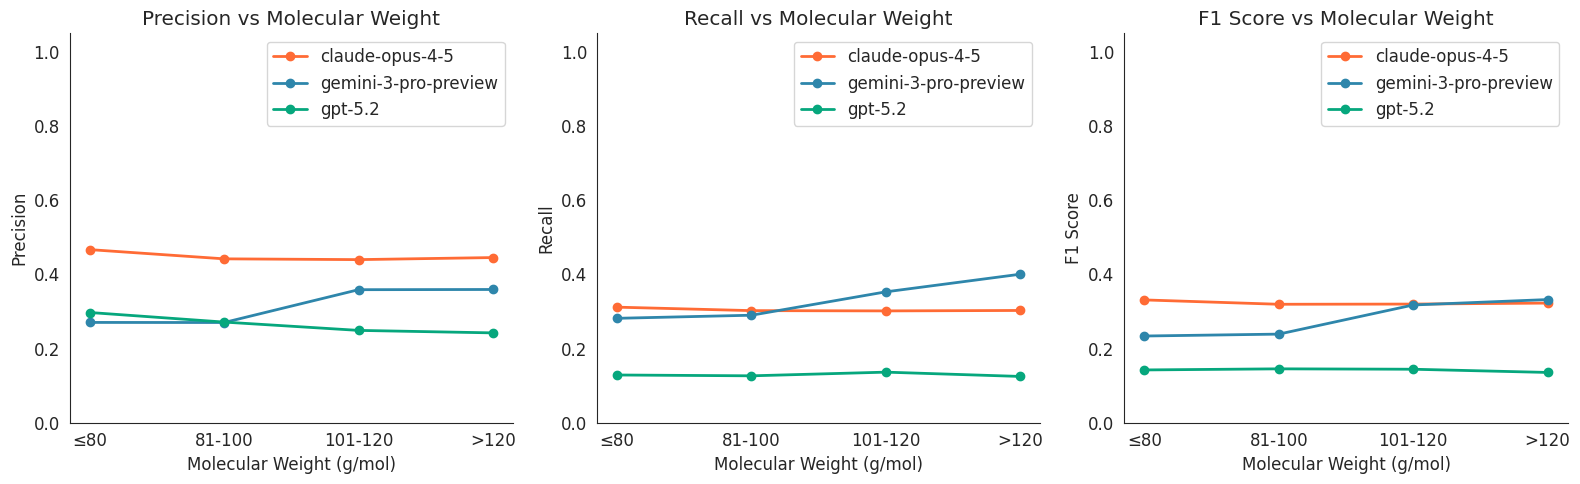

In [14]:
# Stratify by molecular weight
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Create color mapping for models
models = sorted(df['model'].unique())
color_map = {model: custom_colors[i % len(custom_colors)] for i, model in enumerate(models)}

# Create bins for molecular weight
df['mol_weight_bin'] = pd.cut(df['avg_molecular_weight'], 
                               bins=[0, 80, 100, 120, 1000], 
                               labels=['≤80', '81-100', '101-120', '>120'])

# Precision by molecular weight
ax1 = axes[0]
for model in models:
    subset = df[df['model'] == model]
    grouped = subset.groupby('mol_weight_bin', observed=True)['precision'].mean().reset_index()
    ax1.plot(grouped['mol_weight_bin'], grouped['precision'], marker='o', label=model, 
             linewidth=2, color=color_map[model])
ax1.set_xlabel('Molecular Weight (g/mol)')
ax1.set_ylabel('Precision')
ax1.set_title('Precision vs Molecular Weight')
ax1.legend()
ax1.set_ylim([0, 1.05])
sns.despine(ax=ax1)

# Recall by molecular weight
ax2 = axes[1]
for model in models:
    subset = df[df['model'] == model]
    grouped = subset.groupby('mol_weight_bin', observed=True)['recall'].mean().reset_index()
    ax2.plot(grouped['mol_weight_bin'], grouped['recall'], marker='o', label=model, 
             linewidth=2, color=color_map[model])
ax2.set_xlabel('Molecular Weight (g/mol)')
ax2.set_ylabel('Recall')
ax2.set_title('Recall vs Molecular Weight')
ax2.legend()
ax2.set_ylim([0, 1.05])
sns.despine(ax=ax2)

# F1 by molecular weight
ax3 = axes[2]
for model in models:
    subset = df[df['model'] == model]
    grouped = subset.groupby('mol_weight_bin', observed=True)['f1'].mean().reset_index()
    ax3.plot(grouped['mol_weight_bin'], grouped['f1'], marker='o', label=model, 
             linewidth=2, color=color_map[model])
ax3.set_xlabel('Molecular Weight (g/mol)')
ax3.set_ylabel('F1 Score')
ax3.set_title('F1 Score vs Molecular Weight')
ax3.legend()
ax3.set_ylim([0, 1.05])
sns.despine(ax=ax3)

plt.tight_layout()
plt.show()

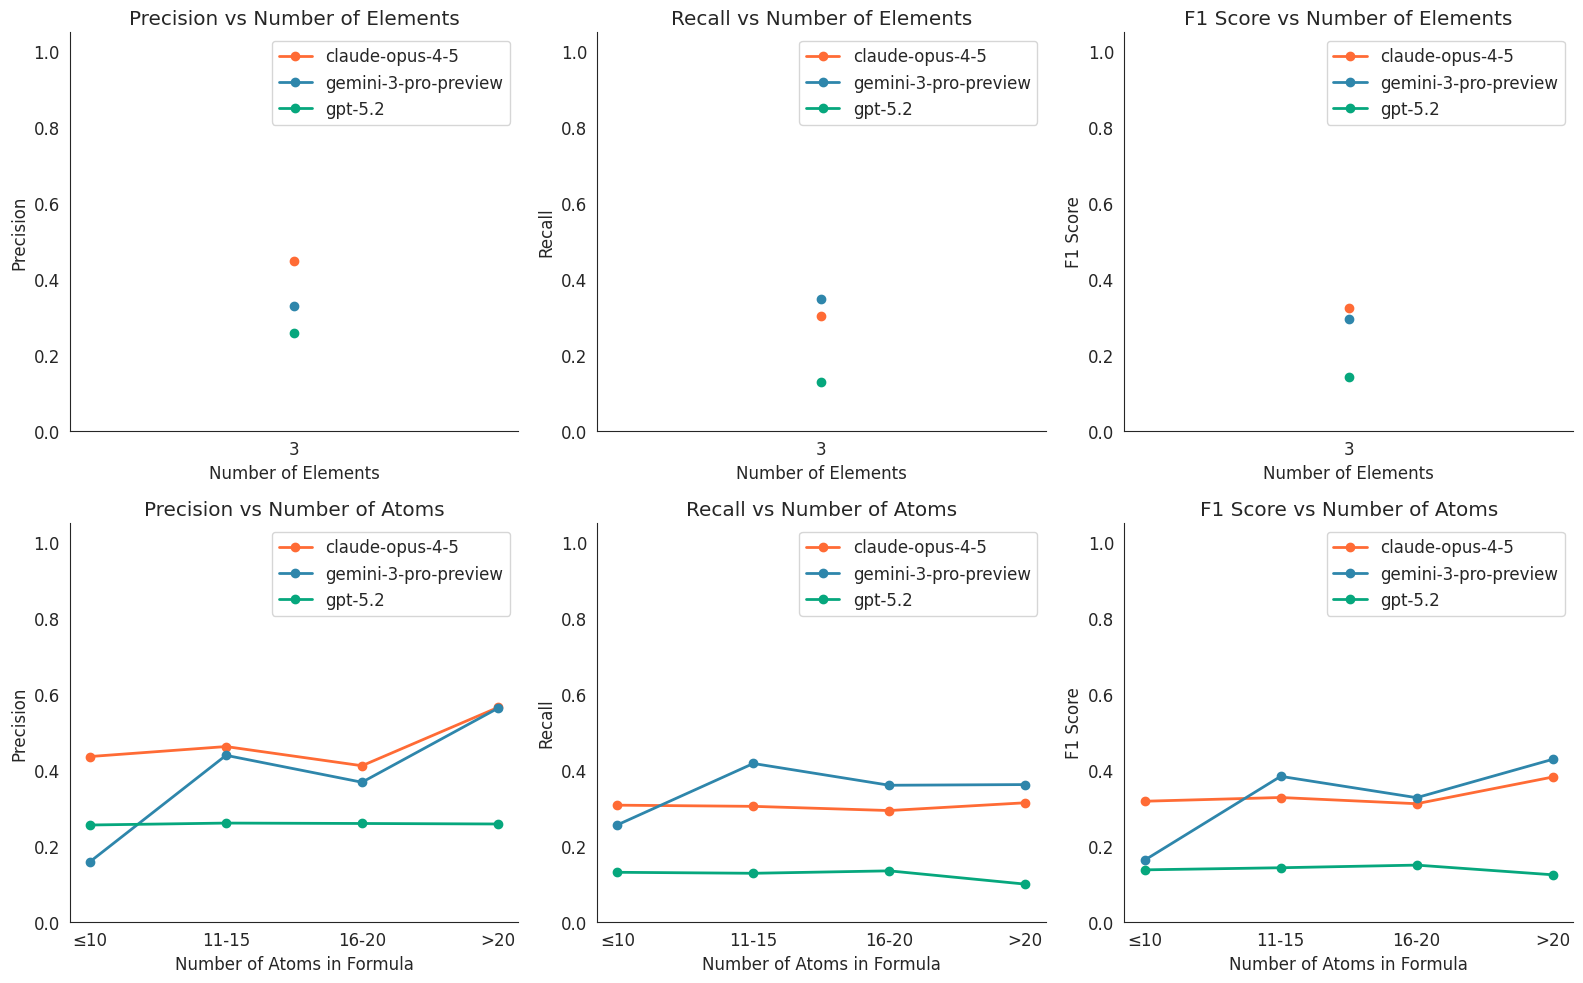

In [15]:
# Stratify by formula complexity
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# Create color mapping for models
models = sorted(df['model'].unique())
color_map = {model: custom_colors[i % len(custom_colors)] for i, model in enumerate(models)}

# Create bins for n_elements and n_atoms
df['n_elements_bin'] = pd.cut(df['n_elements'], bins=[0, 2, 3, 4, 100], labels=['≤2', '3', '4', '>4'])
df['n_atoms_bin'] = pd.cut(df['n_atoms_formula'], bins=[0, 10, 15, 20, 1000], labels=['≤10', '11-15', '16-20', '>20'])

# Precision by n_elements
ax1 = axes[0, 0]
for model in models:
    subset = df[df['model'] == model]
    grouped = subset.groupby('n_elements_bin', observed=True)['precision'].mean().reset_index()
    ax1.plot(grouped['n_elements_bin'], grouped['precision'], marker='o', label=model, 
             linewidth=2, color=color_map[model])
ax1.set_xlabel('Number of Elements')
ax1.set_ylabel('Precision')
ax1.set_title('Precision vs Number of Elements')
ax1.legend()
ax1.set_ylim([0, 1.05])
sns.despine(ax=ax1)

# Recall by n_elements
ax2 = axes[0, 1]
for model in models:
    subset = df[df['model'] == model]
    grouped = subset.groupby('n_elements_bin', observed=True)['recall'].mean().reset_index()
    ax2.plot(grouped['n_elements_bin'], grouped['recall'], marker='o', label=model, 
             linewidth=2, color=color_map[model])
ax2.set_xlabel('Number of Elements')
ax2.set_ylabel('Recall')
ax2.set_title('Recall vs Number of Elements')
ax2.legend()
ax2.set_ylim([0, 1.05])
sns.despine(ax=ax2)

# F1 by n_elements
ax3 = axes[0, 2]
for model in models:
    subset = df[df['model'] == model]
    grouped = subset.groupby('n_elements_bin', observed=True)['f1'].mean().reset_index()
    ax3.plot(grouped['n_elements_bin'], grouped['f1'], marker='o', label=model, 
             linewidth=2, color=color_map[model])
ax3.set_xlabel('Number of Elements')
ax3.set_ylabel('F1 Score')
ax3.set_title('F1 Score vs Number of Elements')
ax3.legend()
ax3.set_ylim([0, 1.05])
sns.despine(ax=ax3)

# Precision by n_atoms
ax4 = axes[1, 0]
for model in models:
    subset = df[df['model'] == model]
    grouped = subset.groupby('n_atoms_bin', observed=True)['precision'].mean().reset_index()
    ax4.plot(grouped['n_atoms_bin'], grouped['precision'], marker='o', label=model, 
             linewidth=2, color=color_map[model])
ax4.set_xlabel('Number of Atoms in Formula')
ax4.set_ylabel('Precision')
ax4.set_title('Precision vs Number of Atoms')
ax4.legend()
ax4.set_ylim([0, 1.05])
sns.despine(ax=ax4)

# Recall by n_atoms
ax5 = axes[1, 1]
for model in models:
    subset = df[df['model'] == model]
    grouped = subset.groupby('n_atoms_bin', observed=True)['recall'].mean().reset_index()
    ax5.plot(grouped['n_atoms_bin'], grouped['recall'], marker='o', label=model, 
             linewidth=2, color=color_map[model])
ax5.set_xlabel('Number of Atoms in Formula')
ax5.set_ylabel('Recall')
ax5.set_title('Recall vs Number of Atoms')
ax5.legend()
ax5.set_ylim([0, 1.05])
sns.despine(ax=ax5)

# F1 by n_atoms
ax6 = axes[1, 2]
for model in models:
    subset = df[df['model'] == model]
    grouped = subset.groupby('n_atoms_bin', observed=True)['f1'].mean().reset_index()
    ax6.plot(grouped['n_atoms_bin'], grouped['f1'], marker='o', label=model, 
             linewidth=2, color=color_map[model])
ax6.set_xlabel('Number of Atoms in Formula')
ax6.set_ylabel('F1 Score')
ax6.set_title('F1 Score vs Number of Atoms')
ax6.legend()
ax6.set_ylim([0, 1.05])
sns.despine(ax=ax6)

plt.tight_layout()
plt.show()

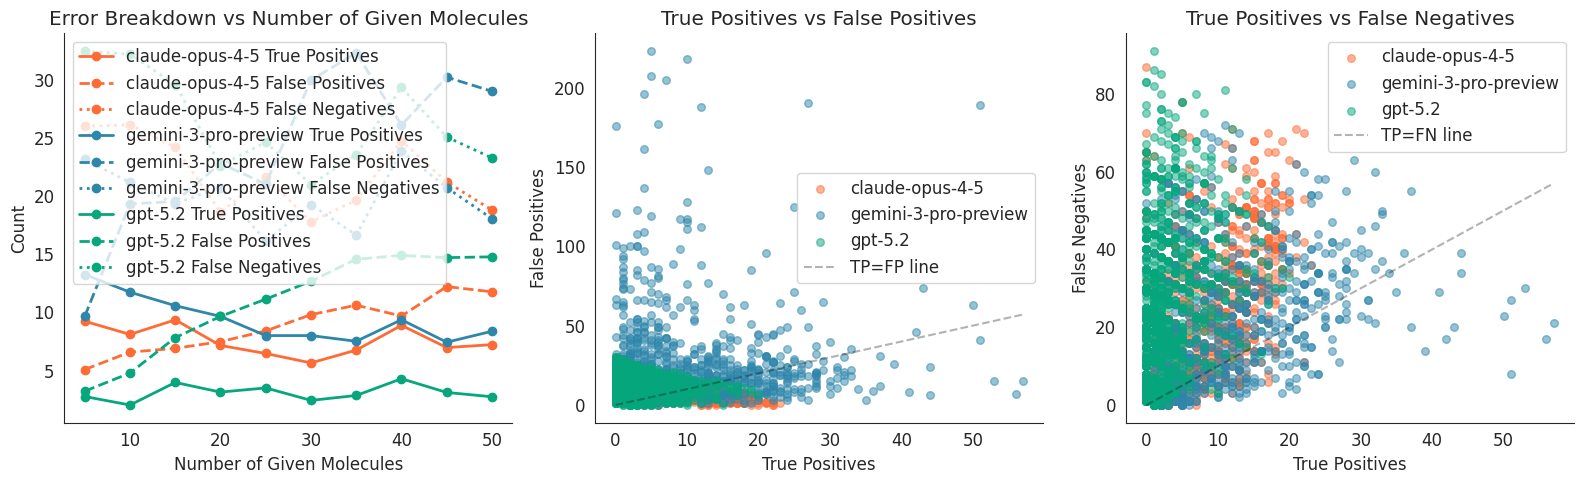

In [16]:
# Error analysis: TP, FP, FN breakdown
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Create color mapping for models
models = sorted(df['model'].unique())
color_map = {model: custom_colors[i % len(custom_colors)] for i, model in enumerate(models)}

# Average TP, FP, FN by n_molecules
ax1 = axes[0]
for model in models:
    subset = df[df['model'] == model]
    for metric, label, style in [('tp', 'True Positives', '-'), ('fp', 'False Positives', '--'), ('fn', 'False Negatives', ':')]:
        grouped = subset.groupby('n_molecules')[metric].mean().reset_index()
        ax1.plot(grouped['n_molecules'], grouped[metric], marker='o', 
                label=f"{model} {label}", linestyle=style, linewidth=2, color=color_map[model])
ax1.set_xlabel('Number of Given Molecules')
ax1.set_ylabel('Count')
ax1.set_title('Error Breakdown vs Number of Given Molecules')
ax1.legend()
sns.despine(ax=ax1)

# TP vs FP scatter
ax2 = axes[1]
for model in models:
    subset = df[df['model'] == model]
    ax2.scatter(subset['tp'], subset['fp'], alpha=0.5, label=model, s=30, color=color_map[model])
ax2.plot([0, df['tp'].max()], [0, df['tp'].max()], 'k--', alpha=0.3, label='TP=FP line')
ax2.set_xlabel('True Positives')
ax2.set_ylabel('False Positives')
ax2.set_title('True Positives vs False Positives')
ax2.legend()
sns.despine(ax=ax2)

# TP vs FN scatter
ax3 = axes[2]
for model in models:
    subset = df[df['model'] == model]
    ax3.scatter(subset['tp'], subset['fn'], alpha=0.5, label=model, s=30, color=color_map[model])
ax3.plot([0, df['tp'].max()], [0, df['tp'].max()], 'k--', alpha=0.3, label='TP=FN line')
ax3.set_xlabel('True Positives')
ax3.set_ylabel('False Negatives')
ax3.set_title('True Positives vs False Negatives')
ax3.legend()
sns.despine(ax=ax3)

plt.tight_layout()
plt.show()

## Detailed Performance Tables

In [17]:
# Create detailed table stratified by n_molecules
summary_by_n = []

for model in sorted(df['model'].unique()):
    for n_mol in sorted(df['n_molecules'].unique()):
        subset = df[(df['model'] == model) & (df['n_molecules'] == n_mol)]
        if len(subset) == 0:
            continue
        
        summary_by_n.append({
            'Model': model,
            'N_given': n_mol,
            'Count': len(subset),
            'Avg_Missing': f"{subset['n_missing'].mean():.1f}",
            'Precision': f"{subset['precision'].mean():.3f}",
            'Recall': f"{subset['recall'].mean():.3f}",
            'F1': f"{subset['f1'].mean():.3f}",
            'Exact_Match': f"{subset['exact_match'].mean():.3f}",
            'Avg_TP': f"{subset['tp'].mean():.1f}",
            'Avg_FP': f"{subset['fp'].mean():.1f}",
            'Avg_FN': f"{subset['fn'].mean():.1f}",
        })

summary_by_n_df = pd.DataFrame(summary_by_n)
print("\n" + "=" * 120)
print("PERFORMANCE BY NUMBER OF GIVEN MOLECULES")
print("=" * 120)
print(summary_by_n_df.to_string(index=False))


PERFORMANCE BY NUMBER OF GIVEN MOLECULES
               Model  N_given  Count Avg_Missing Precision Recall    F1 Exact_Match Avg_TP Avg_FP Avg_FN
     claude-opus-4-5        5    100        35.2     0.625  0.348 0.418       0.000    9.2    5.1   26.0
     claude-opus-4-5       10    100        34.2     0.518  0.321 0.347       0.000    8.1    6.6   26.1
     claude-opus-4-5       15    100        33.6     0.565  0.355 0.394       0.000    9.4    6.9   24.2
     claude-opus-4-5       20    100        25.8     0.480  0.350 0.376       0.000    7.2    7.5   18.6
     claude-opus-4-5       25    100        28.1     0.396  0.311 0.297       0.000    6.5    8.4   21.7
     claude-opus-4-5       30    100        23.4     0.333  0.308 0.277       0.000    5.7    9.8   17.8
     claude-opus-4-5       35    100        26.4     0.350  0.283 0.247       0.000    6.8   10.6   19.7
     claude-opus-4-5       40    100        33.6     0.467  0.259 0.317       0.000    8.9    9.7   24.8
     claude-o

In [18]:
# Create detailed table stratified by molecular properties
summary_by_props = []

for model in sorted(df['model'].unique()):
    # By n_missing
    for bin_val in df['n_missing_bin'].cat.categories:
        subset = df[(df['model'] == model) & (df['n_missing_bin'] == bin_val)]
        if len(subset) == 0:
            continue
        
        summary_by_props.append({
            'Model': model,
            'Property': 'N_Missing',
            'Bin': str(bin_val),
            'Count': len(subset),
            'Precision': f"{subset['precision'].mean():.3f}",
            'Recall': f"{subset['recall'].mean():.3f}",
            'F1': f"{subset['f1'].mean():.3f}",
        })
    
    # By molecular weight
    for mw_bin in df['mol_weight_bin'].cat.categories:
        subset = df[(df['model'] == model) & (df['mol_weight_bin'] == mw_bin)]
        if len(subset) == 0:
            continue
        
        summary_by_props.append({
            'Model': model,
            'Property': 'Mol_Weight',
            'Bin': str(mw_bin),
            'Count': len(subset),
            'Precision': f"{subset['precision'].mean():.3f}",
            'Recall': f"{subset['recall'].mean():.3f}",
            'F1': f"{subset['f1'].mean():.3f}",
        })
    
    # By n_elements
    for elem_bin in df['n_elements_bin'].cat.categories:
        subset = df[(df['model'] == model) & (df['n_elements_bin'] == elem_bin)]
        if len(subset) == 0:
            continue
        
        summary_by_props.append({
            'Model': model,
            'Property': 'N_Elements',
            'Bin': str(elem_bin),
            'Count': len(subset),
            'Precision': f"{subset['precision'].mean():.3f}",
            'Recall': f"{subset['recall'].mean():.3f}",
            'F1': f"{subset['f1'].mean():.3f}",
        })
    
    # By n_atoms
    for atom_bin in df['n_atoms_bin'].cat.categories:
        subset = df[(df['model'] == model) & (df['n_atoms_bin'] == atom_bin)]
        if len(subset) == 0:
            continue
        
        summary_by_props.append({
            'Model': model,
            'Property': 'N_Atoms',
            'Bin': str(atom_bin),
            'Count': len(subset),
            'Precision': f"{subset['precision'].mean():.3f}",
            'Recall': f"{subset['recall'].mean():.3f}",
            'F1': f"{subset['f1'].mean():.3f}",
        })

summary_by_props_df = pd.DataFrame(summary_by_props)
print("\n" + "=" * 100)
print("PERFORMANCE BY MOLECULAR PROPERTIES")
print("=" * 100)
print(summary_by_props_df.to_string(index=False))


PERFORMANCE BY MOLECULAR PROPERTIES
               Model   Property     Bin  Count Precision Recall    F1
     claude-opus-4-5  N_Missing     1-5    114     0.119  0.402 0.175
     claude-opus-4-5  N_Missing    6-10    105     0.322  0.417 0.346
     claude-opus-4-5  N_Missing   11-15     86     0.383  0.363 0.361
     claude-opus-4-5  N_Missing   16-20    101     0.369  0.314 0.333
     claude-opus-4-5  N_Missing   21-25     94     0.422  0.285 0.335
     claude-opus-4-5  N_Missing   26-30     86     0.512  0.313 0.383
     claude-opus-4-5  N_Missing     >30    414     0.591  0.235 0.331
     claude-opus-4-5 Mol_Weight     ≤80    142     0.467  0.312 0.331
     claude-opus-4-5 Mol_Weight  81-100    204     0.442  0.302 0.319
     claude-opus-4-5 Mol_Weight 101-120    285     0.440  0.302 0.320
     claude-opus-4-5 Mol_Weight    >120    369     0.445  0.303 0.323
     claude-opus-4-5 N_Elements       3   1000     0.446  0.304 0.322
     claude-opus-4-5    N_Atoms     ≤10    361     0.

In [19]:
# Export enriched results to CSV for further analysis
output_path = 'analysis_results/q3_enriched_results.csv'
Path('analysis_results').mkdir(exist_ok=True)
df.to_csv(output_path, index=False)
print(f"\nEnriched results exported to: {output_path}")

# Export summary tables
summary_by_n_df.to_csv('analysis_results/q3_summary_by_n_molecules.csv', index=False)
summary_by_props_df.to_csv('analysis_results/q3_summary_by_properties.csv', index=False)
print("Summary tables exported to analysis_results/")


Enriched results exported to: analysis_results/q3_enriched_results.csv
Summary tables exported to analysis_results/
